## This notebook shows how to get the word timing information from a TTS model.
### Note: it doesn't always work, cause some word combinations are pronounced as one word 

In [398]:
import sys
sys.path.append('../') # so that we can import packages from parent folder

from TTS.utils.synthesizer import Synthesizer
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [399]:
tts_path = "/Users/tindelllockett/Library/Application Support/tts/tts_models--en--vctk--vits/model_file.pth"
tts_config_path = "/Users/tindelllockett/Library/Application Support/tts/tts_models--en--vctk--vits/config.json"
speakers_file_path = "/Users/tindelllockett/Library/Application Support/tts/tts_models--en--vctk--vits/speaker_ids.json"

In [400]:
# Define text, model name, speaker index, and output path
text = "hello world; this is an example sentence"
# text = "Tteokbokki is a popular Korean dish consisting of cylindrical rice cakes, typically 2 to 3 inches long, bathed in a vibrant red, glossy sauce."
# text = "Khachapuri: A boat-shaped, golden-brown bread encases a filling of molten white cheese; In the center, a bright yellow, partially cooked egg yolk is nestled, with a small dollop of glistening butter atop it; The pointed ends of the bread are slightly crispy, and the dish is served hot, emitting a gentle steam."
speaker_idx = "p225"
out_path = "out.wav"

In [401]:


# Initialize the synthesizer
synthesizer = Synthesizer(
        tts_checkpoint=tts_path,
        tts_config_path=tts_config_path,
        tts_speakers_file=speakers_file_path,
        use_cuda=False,
    );



 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > initialization of speaker-embedding layers.


In [402]:
synthesizer.tts_model.speaker_manager.speaker_names[:4]

['ED\n', 'p225', 'p226', 'p227']

In [403]:
output = synthesizer.tts(text=text,speaker_name="p225",return_extra_outputs=True)
Audio(output[0], rate=22050)

 > Text splitted to sentences.
['hello world; this is an example sentence']
 > Processing time: 0.920280933380127
 > Real-time factor: 0.2881759057747074


In [404]:
tokens = synthesizer.tts_model.tokenizer.text_to_ids(text)
pre_tokenized_text_blnk = [synthesizer.tts_model.tokenizer.decode([y]) for y in tokens]
# replace <blnk> with space
pre_tokenized_text = [x if x != '<BLNK>' else '_' for x in pre_tokenized_text_blnk]
space_indices = [i for i, phoneme in enumerate(pre_tokenized_text) if phoneme == ' ']
space_indices = [0] + space_indices


In [405]:
phoneme_durations = output[1]['outputs']['durations'].squeeze()
phoneme_timestamps = np.cumsum(phoneme_durations.squeeze())



In [406]:
word_timestamps = []
start_idx = 0
word_timestamps = [float(phoneme_timestamps[space_idx]) for space_idx in space_indices]
word_timestamps[0] = 0.0

word_timestamps

[0.0, 35.0, 75.0, 92.0, 104.0, 116.0, 166.0]

In [407]:
# zip pre_tokenized_text and phoneme_timestamps
paired_tokens_timestamps = list(zip(pre_tokenized_text, phoneme_timestamps))
paired_tokens_timestamps[:14]

[('_', tensor(1.)),
 ('h', tensor(4.)),
 ('_', tensor(5.)),
 ('ə', tensor(8.)),
 ('_', tensor(9.)),
 ('l', tensor(17.)),
 ('_', tensor(19.)),
 ('ˈ', tensor(22.)),
 ('_', tensor(24.)),
 ('o', tensor(27.)),
 ('_', tensor(28.)),
 ('ʊ', tensor(29.)),
 ('_', tensor(33.)),
 (' ', tensor(35.))]

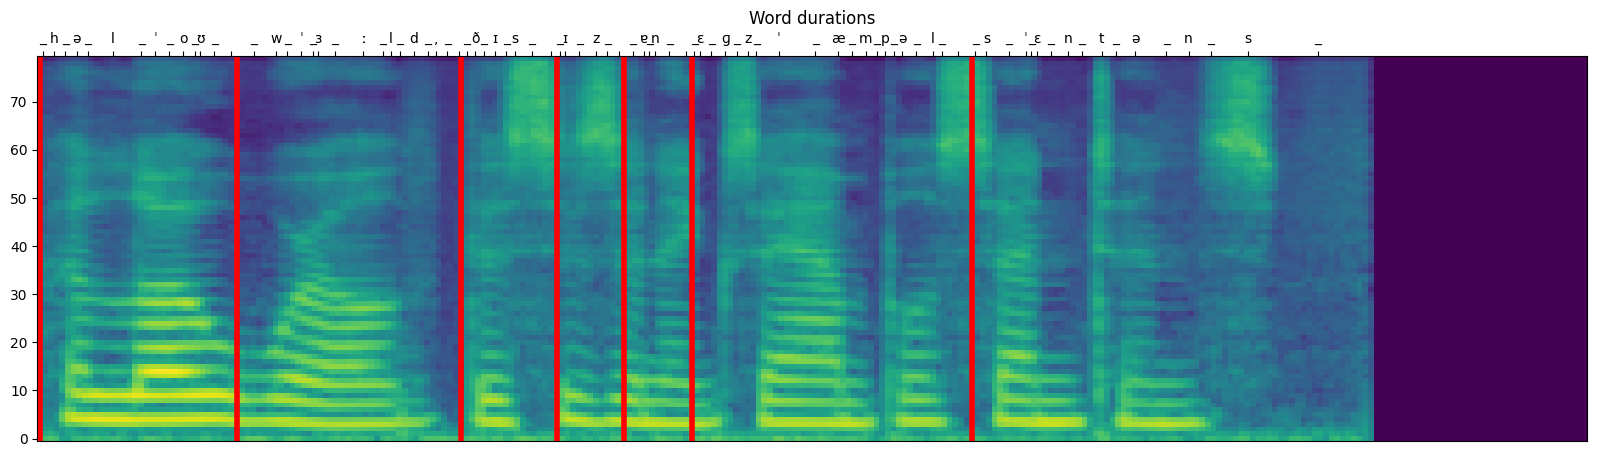

In [415]:
# plot the spectrogram with xticks
spec = synthesizer.tts_model.ap.melspectrogram(np.array(output[0]))
plt.figure(figsize=(20,5))
plt.imshow(spec, origin="lower", aspect='auto', interpolation='none')
# shift the xticks to the middle of the bins
plt.xticks(np.cumsum(output[1]["outputs"]["durations"].cpu().numpy()[0][0]) - output[1]["outputs"]["durations"].cpu().numpy()[0][0] / 2, pre_tokenized_text, rotation=0)
# draw a vertical line for each token
for x in word_timestamps:
    plt.axvline(x, color="red", linewidth=4)

plt.gca().xaxis.tick_top()
plt.title("Word durations")
plt.show()

In [409]:
beep = np.sin(2 * np.pi * 1000 * np.arange(0, 0.1, 1/22050))
len(beep)
Audio(beep, rate=22050)

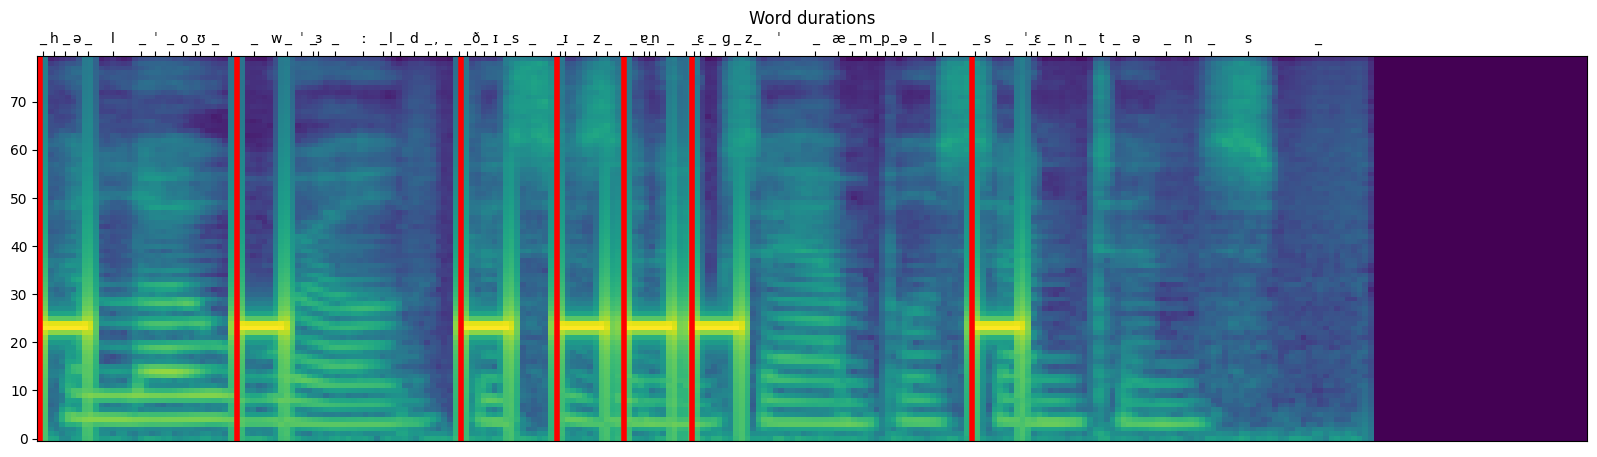

In [410]:
# Get the audio samples from the synthesizer
audio_samples = np.array(output[0])

# Convert the word start timestamps to sample indices
word_sample_indices = [int(start/86. * 22050) for start in word_timestamps]

# Insert the beep at each word start
for start_sample in word_sample_indices:
    end_sample = start_sample + len(beep)
    if end_sample > len(audio_samples):
        end_sample = len(audio_samples)
        beep = beep[:end_sample - start_sample]  # Truncate beep if necessary
    audio_samples[start_sample:end_sample] += beep


# plot the spectrogram
spec = synthesizer.tts_model.ap.melspectrogram(np.array(audio_samples))

# plot the spectrogram with xticks
spec = synthesizer.tts_model.ap.melspectrogram(np.array(audio_samples))
plt.figure(figsize=(20,5))
plt.imshow(spec, origin="lower", aspect='auto', interpolation='none')
# create labels at the xticks
# plt.xticks(np.cumsum(output[1]["outputs"]["durations"].cpu().numpy()), pre_tokenized_text, rotation=0)
# shift the xticks to the middle of the bins
plt.xticks(np.cumsum(output[1]["outputs"]["durations"].cpu().numpy()[0][0]) - output[1]["outputs"]["durations"].cpu().numpy()[0][0] / 2, pre_tokenized_text, rotation=0)
# draw a vertical line for each token
for x in word_timestamps:
    plt.axvline(x, color="red", linewidth=4)

plt.gca().xaxis.tick_top()
plt.title("Word durations")
plt.show()

# Play the modified audio
Audio(audio_samples, rate=22050)


In [411]:
import cv2
import os
def create_word_video(word, duration, background_image_path, output_file, font=cv2.FONT_HERSHEY_SIMPLEX, font_scale=2, font_thickness=2, fps=30, color=(0,0,0)):
    background_image = cv2.imread(background_image_path)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    height, width, _ = background_image.shape
    out = cv2.VideoWriter(output_file, fourcc, fps, (width, height))

    (text_width, text_height), _ = cv2.getTextSize(word, font, font_scale, font_thickness)

    text_size = cv2.getTextSize(word, font, font_scale, font_thickness)[0]

    # Calculate the position to center the text
    x = (width - text_size[0]) // 2
    y = (height + text_size[1]) // 2

    frames_to_write = int(fps * duration)
    for _ in range(frames_to_write):
        frame = background_image.copy()
        cv2.putText(frame, word, (x, y), font, font_scale, color, font_thickness)
        out.write(frame)

    out.release()

create_word_video('Hello', 2, 'images/image.png', 'output/word.mp4')

In [412]:
import soundfile as sf
import subprocess

def create_sentence_video(sentence, word_timestamps,audio_samples, background_image_path, output_file='output/sentence.mp4', fps=30, audio_rate=22050):
    # Split the sentence into words
    words = sentence.split()
    # Total duration of the audio in seconds
    audio_duration = len(audio_samples) / audio_rate

    # Convert the timestamps to durations
    word_durations = [word_timestamps[i+1] - word_timestamps[i] for i in range(len(word_timestamps) - 1)]
    # Add duration for the last word, from its start timestamp to the end of the audio
    word_durations.append(audio_duration - word_timestamps[-1])
    
    if len(words) != len(word_durations):
        raise ValueError(f"Number of words must match the number of durations. {len(words)} != {len(word_durations)}")

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    
    temp_video_file = 'temp_video.mp4'
    background_image = cv2.imread(background_image_path)
    height, width, _ = background_image.shape

    out = cv2.VideoWriter(temp_video_file, fourcc, fps, (width, height))

    for word, duration in zip(words, word_durations):
        # Create the word video
        word_file = 'temp_word.mp4'
        create_word_video(word, duration, background_image_path, word_file)

        # Read the word video and write it to the output
        cap = cv2.VideoCapture(word_file)
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            out.write(frame)
        cap.release()

        # Remove temporary word file
        os.remove(word_file)

    out.release()

    # Temporary audio file
    temp_audio_file = 'temp_audio.wav'
    sf.write(temp_audio_file, audio_samples, audio_rate)

    # Combine video and audio using ffmpeg
    command = ['ffmpeg', '-y', '-i', temp_video_file, '-i', temp_audio_file, '-c:v', 'copy', '-c:a', 'aac', '-strict', 'experimental', output_file]
    subprocess.run(command)

    # Remove temporary files
    os.remove(temp_video_file)
    os.remove(temp_audio_file)

    print(f"Sentence video with audio created successfully: {output_file}")

    print(f"Sentence video created successfully: {output_file}")

In [413]:
word_timestamps_seconds = [start/86. for start in word_timestamps]
create_sentence_video(text, word_timestamps_seconds, output[0], "./image.png")

Sentence video with audio created successfully: sentence.mp4
Sentence video created successfully: sentence.mp4


ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.3 (clang-1403.0.22.14.1)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.0 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --di